## Libraray Import

In [4]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

## Submission to Json

In [1]:
import pandas as pd
import json

# submission.csv 경로
csv_dir = "/opt/ml/baseline/mmdetection/work_dirs/swinL20_swinbase_ensemble.csv"
pred_df = pd.read_csv(csv_dir) # csv 읽기

dic = {
    "info": {},
    "licenses": [],
    "images": [],               # 이미지 list
    "categories": [],           # class 종류들의 list
    "annotations": []           # annotation list
}

dic["info"] = {
    "year": 2021,
    "version": "1.0",
    "description": "Recycle Trash",
    "contributor": "Upstage",
    "url": None,
    "date_created": "2021-02-02 01:10:00"
}

dic["licenses"] = [
    {
      "id": 0, "name": "CC BY 4.0",
      "url": "https://creativecommons.org/licenses/by/4.0/deed.ast"
    }
]

dic["categories"] = [
    {"id": 0,"name": "General trash","supercategory": "General trash"},
    {"id": 1,"name": "Paper","supercategory": "Paper"},
    {"id": 2,"name": "Paper pack","supercategory": "Paper pack"},
    {"id": 3,"name": "Metal","supercategory": "Metal"},
    {"id": 4,"name": "Glass","supercategory": "Glass"},
    {"id": 5,"name": "Plastic","supercategory": "Plastic"},
    {"id": 6,"name": "Styrofoam","supercategory": "Styrofoam"},
    {"id": 7,"name": "Plastic bag","supercategory": "Plastic bag"},
    {"id": 8,"name": "Battery","supercategory": "Battery"},
    {"id": 9,"name": "Clothing","supercategory": "Clothing"}
]

file_names = pred_df['image_id'].values.tolist()
bboxes = pred_df['PredictionString'].values.tolist()

# dic["images"]
for f in file_names:
    dic["images"].append({
        "width": 1024, "height": 1024,
        "file_name": f,
        "license": 0,
        "flickr_url": None, 
        "coco_url": None,
        "id": int(f[5:9])
    })


box_id = 0
for img_idx,box in enumerate(bboxes):
    lst = []
    if type(box) == float:
        continue
    for i,b in enumerate(box.split(" ")):
        if i%6 == 0 and i != 0:
            # test.json에서는 비어있는 부분
            dic["annotations"].append({
                "image_id": img_idx,          # 이미지 id
                "category_id": int(lst[0]),   # 이미지 class
                "score": float(lst[1]),
                "area": (float(lst[4]) - float(lst[2])) * (float(lst[5]) - float(lst[3])),
                "bbox": [                     # bbox 좌표
                    float(lst[2]),
                    float(lst[3]),
                    float(lst[4]) - float(lst[2]),
                    float(lst[5]) - float(lst[3])
                ],
                "iscrowd": 0,            # ??
                "id": box_id             # 박스의 ID: 1,2,3, ...
            })
            lst = []
            box_id += 1
        lst.append(b)

json_dir = '/opt/ml/baseline/baseline_cv11/swinL20_swinbase_ensemble.json'
with open(json_dir,'w') as f:
    json.dump(dic,f)

## Convert json to dataframe

In [5]:
coco = COCO('/opt/ml/baseline/baseline_cv11/swinL20_swinbase_ensemble.json')
train_df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass","Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(ann_ids)
    filename = imageinfo['file_name']
    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['imageid'] = image_ids
train_df['classname'] = class_name
train_df['classid'] = class_id
train_df['xmin'] = x_min
train_df['ymin'] = y_min
train_df['xmax'] = x_max
train_df['ymax'] = y_max


loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


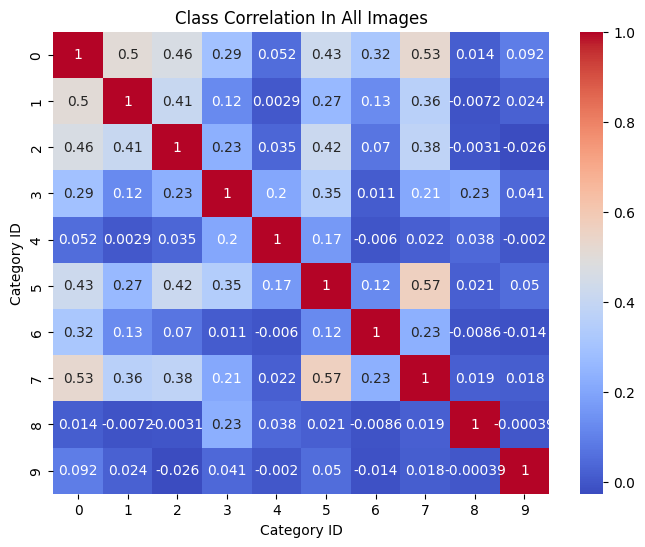

In [6]:
# 모든 이미지에 대한 상관관계
class_counts = train_df['classid'].value_counts()

# 클래스 간의 상관 행렬 생성
correlation_matrix = train_df.groupby('imageid')['classid'].value_counts().unstack(fill_value=0)
correlation_matrix = correlation_matrix.corr()

# 상관 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Category ID')
plt.ylabel('Category ID')
plt.title('Class Correlation In All Images')
plt.show()